In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL.Image
from matplotlib.animation import ArtistAnimation

In [2]:
grid = np.load('processed.npy')
grid = grid[0:100,0:100]

In [3]:
def start_fire(m,n,p=0.001,burning_time=10): #width,height,prob
    M = np.zeros([m,n])
    count_down = np.zeros([m,n])
    M_p = np.random.rand(m,n)
    M[M_p>(1-p)] = 3
    count_down[M_p>(1-p)] = burning_time
    return M,count_down

In [4]:
def start_fire_grid(grid,p=0.0001,burning_time=10):
    m = np.size(grid,0)
    n = np.size(grid,1)
    M = np.zeros([m,n])
    count_down = np.zeros([m,n])
    M_p = np.random.rand(m,n)
    M[M_p>(1-p)] = 3
    M[grid>0] = -1 #inflammable
    count_down[M==3] = burning_time
    return M,count_down

In [5]:
def burning_prob(wind_dir): #[0,1] from south [1,0] from east
    
    prob = np.zeros(6)
    distance = np.zeros(6)
    if wind_dir[0]!=0:
        theta = np.arctan(wind_dir[1]/wind_dir[0])
    else:
        if(wind_dir[1]>0):
            theta = np.pi/2
        else:
            theta = -np.pi/2
    theta = np.pi - theta

    distance[0] = abs(theta-2/3*np.pi)
    distance[1] = abs(theta-1/3*np.pi)
    distance[2] = abs(theta)
    distance[3] = abs(theta-5/3*np.pi)
    distance[4] = abs(theta-4/3*np.pi)
    distance[5] = abs(theta-np.pi)

    for i in range(6):
        if distance[i]>np.pi:
            distance[i] = 2*np.pi - distance[i]
        prob[i] = random.uniform(1-distance[i]/np.pi,1)
        #prob[i] = random.uniform(1-np.sin(distance[i]/2),1)
    
    return prob
      
    '''
    prob = np.zeros(4)
    beta = 2

    p_x = 0.8*(1-np.exp(-beta*abs(wind_dir[0])))
    p_y = 0.8*(1-np.exp(-beta*abs(wind_dir[1])))
    prob[0] = random.uniform(0.5-np.sign(wind_dir[0])*p_x, 1) #x-
    prob[2] = random.uniform(0.5+np.sign(wind_dir[0])*p_x, 1) #x+
    prob[1] = random.uniform(0.5-np.sign(wind_dir[1])*p_y,1) #y-
    prob[3] = random.uniform(0.5+np.sign(wind_dir[1])*p_y,1) #y+
    return prob
    '''

In [6]:
def if_burning_around(M,i,j,wind_dir): #simplest
    tmp = 0
    m = np.size(M,0) #size
    n = np.size(M,1)
    prob = burning_prob(wind_dir)
    tol = 0.7

    if i%2==0 :
        if i!=0 and M[i-1,j] == 3 and prob[0]>tol: #1
            tmp = 1
        elif i!=0 and j!=n-1 and M[i-1,j+1] == 3 and prob[1]>tol: #2
            tmp = 1
        elif j!=0 and M[i,j-1] == 3 and prob[5]>tol: #6
            tmp = 1
        elif j!=n-1 and M[i,j+1] == 3 and prob[2]>tol: #3
            tmp = 1  
        elif i!=m-1 and M[i+1,j] == 3 and prob[4]>tol: #5
            tmp = 1
        elif i!=m-1 and j!=n-1 and M[i+1,j+1] == 3 and prob[3]>tol: #4
            tmp = 1
    else:
        if i!=0 and j!=0 and M[i-1,j-1] == 3 and prob[0]>tol: #1
            tmp = 1
        elif i!=0 and M[i-1,j] == 3 and prob[1]>tol: #2
            tmp = 1
        elif j!=0 and M[i,j-1] == 3 and prob[5]>tol: #6
            tmp = 1
        elif j!=n-1 and M[i,j+1] == 3 and prob[2]>tol: #3
            tmp = 1
        elif i!=m-1 and j!=0 and M[i+1,j-1] == 3 and prob[4]>tol: #5
            tmp = 1
        elif i!=m-1 and M[i+1,j] == 3 and prob[3]>tol: #4
            tmp = 1

    if tmp==1 : return True
    else: return False

In [7]:
def update(M,count_down,density,burning_time = 10,growing_time = 50,wind_dir=[0,0]):
    m = np.size(M,0) #size
    n = np.size(M,1)
    M_copy = np.zeros([m,n])
    M_copy[M==-1] = -1
    count_down_copy = count_down
    for i in np.arange(m):
        for j in np.arange(n):
            if(count_down_copy[i,j]!=0):
                count_down_copy[i,j] -= 1
            if(M[i,j]==0): #flammable
                if(if_burning_around(M,i,j,wind_dir)):
                    M_copy[i,j] = 3
                    count_down_copy[i,j] = burning_time*density[i,j]
            elif(M[i,j]==3 and count_down_copy[i,j]==0):#burning
                #burnt time reached     
                M_copy[i,j] = 2 #burnt
            elif(M[i,j]==3 and count_down_copy[i,j]!=0):
                M_copy[i,j] = 3
            elif(M[i,j]==2): #burnt
                M_copy[i,j] = 1 #growing
                count_down_copy[i,j] = np.random.randint(growing_time-10,growing_time+10)
            elif(M[i,j]==1 and count_down_copy[i,j]==0): 
                M_copy[i,j] = 0 #flammable
            elif(M[i,j]==1 and count_down_copy[i,j]!=0): 
                M_copy[i,j] = 1 
    return M_copy,count_down_copy

In [8]:
def colormap(value):
    if(value==-1):
        return 'black'
    elif(value==0):
        return 'y'
    elif(value==1):
        return 'g'
    elif(value==2):
        return 'b'
    elif(value==3):
        return 'r'

In [9]:
def plot_M(M,ax):
    ax.axis('off')
    '''
    m = np.size(M,0) #size
    n = np.size(M,1)
    line = []
    
    x,y = np.meshgrid(np.arange(m),np.arange(n))
    x = x.flatten()
    y = y.flatten()
    categories = M.flatten()

    color_map = {-1:'black',0:'y',1:'g',2:'b',3:'black'}
    colors = [color_map[cat] for cat in categories]
    for cat in color_map:
        mask = categories == cat
        line.append(ax.scatter(x[mask], y[mask], c=color_map[cat], label=cat,s=0.1))
    '''
    
    return ax.imshow(M,cmap='Reds')

In [10]:
def plot_mesh(M):
    m = np.size(M,0) #size
    n = np.size(M,1)

    x,y = np.meshgrid(np.arange(m),np.arange(n))

    plt.pcolormesh(x, y, M)
    plt.show()

In [11]:
def wind(i,N):
    theta = np.pi/N*i
    return [50*np.cos(theta),50*np.sin(theta)]

KeyboardInterrupt: 

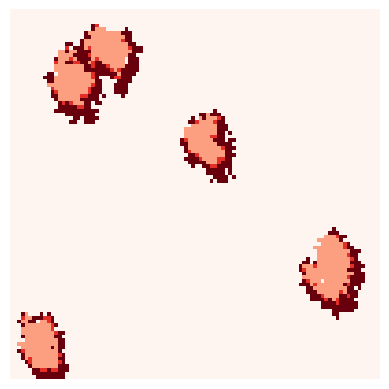

In [ ]:


n= 100
M,count_down = start_fire(n,n)
#density = np.random.randint(1,6,size=(m,n))
density = np.zeros([n,n])+1
'''
for i in range(n):
    for j in range(n):
        density[i,j] = int(5*np.exp(-((2*i-n)/n)**2-((2*j-n)/n)**2))+1 
plot_mesh(density)
'''
fig, ax = plt.subplots()
artists = []
N = 300

for i in range(N):
    M,count_down = update(M,count_down,density,burning_time=5,wind_dir=[2,2])

    line = plot_M(M,ax)
    artists.append(line)
 
anim = ArtistAnimation(fig, artists)
anim.save('fire_density.gif', writer='imagemagick')

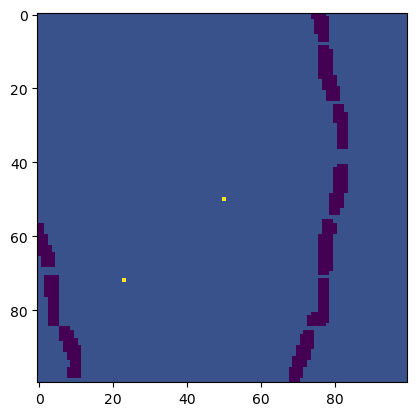

MovieWriter imagemagick unavailable; using Pillow instead.


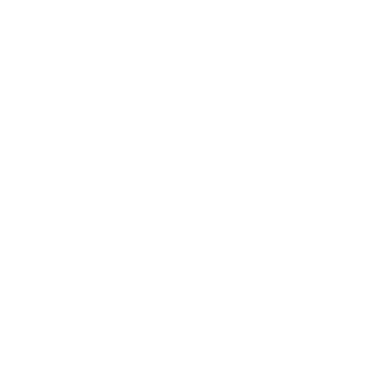

In [13]:
M,count_down = start_fire_grid(grid)
M[50,50] = 3
count_down[50,50] = 2
plt.imshow(M)
plt.show()
#density = np.random.randint(1,6,size=(m,n))
m = np.size(M,0) 
n = np.size(M,1)
density = np.zeros([m,n])+1

fig, ax = plt.subplots()
artists = []
N = 100


M_tracked = np.zeros(shape=(N + 1, M.shape[0], M.shape[1]))
M_tracked[0] = M

for i in range(N):
    M,count_down = update(M,count_down,density,burning_time=5,wind_dir=[1,-1])
    M_tracked[i + 1] = M
    line = plot_M(M,ax)
    artists.append([line])
 
anim = ArtistAnimation(fig, artists)
anim.save('fire_density_small.gif', writer='imagemagick')
np.save('M_tracked.npy', M_tracked)